In [46]:
# Don't look at this notebook through a peephole
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [47]:
from astropy.table import Table
r=Table.read('../data/Cluster-narrow.hdf5', format='hdf5')
r.info()

<Table length=125240>
           name            dtype    unit                                             description                                           n_bad
------------------------- ------- -------- ----------------------------------------------------------------------------------------------- -----
                source_id   int64                                                                                                              0
                       ra float64      deg                                                                                 Right ascension     0
                      dec float64      deg                                                                                     Declination     0
                     pmra float64 mas / yr                                                      Proper motion in right ascension direction     0
                    pmdec float64 mas / yr                                                          Proper m

In [48]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
customSimbad = Simbad()
customSimbad.remove_votable_fields('coordinates')
customSimbad.add_votable_fields('ra(d;A;ICRS;;)', 'dec(d;D;ICRS;;)')
simbad_result = customSimbad.query_objects(["NGC869", "NGC884"])
simbad_result.keep_columns(['MAIN_ID', 'RA_d_A_ICRS__', 'DEC_d_D_ICRS__'])
simbad_result.rename_column('MAIN_ID', 'ID')
simbad_result.rename_column('RA_d_A_ICRS__', 'RA')
simbad_result.rename_column('DEC_d_D_ICRS__', 'DEC')
simbad_result

cluster_center = SkyCoord(ra=np.mean(simbad_result['RA']), dec=np.mean(simbad_result['DEC']), unit=(u.degree, u.degree) , frame='icrs')
cluster_ngc869 = SkyCoord(ra=simbad_result[0]['RA'], dec=simbad_result[0]['DEC'], unit=(u.degree, u.degree) , frame='icrs')
cluster_ngc884 = SkyCoord(ra=simbad_result[1]['RA'], dec=simbad_result[1]['DEC'], unit=(u.degree, u.degree) , frame='icrs')

# Determining Cluster Membership
We start with the narrow (2deg) box search near the double-cluster's known location from Simbad. In order to determine cluster membership parameters, we look specifically at the cores of the two clusters, following the analysis of (Zhong, Chen 2019). The idea here is that we'd like to create a gaussian in proper motion space that is representative of the cluster, where field stars in our fitting sample are noise that will be described by another gaussian and subtracted out during the fit. In order to give the fitting algorithm the strongest signal to work with for finding the cluster, the input is only stars within 10 arc minutes of the cluster centers. This 10 arc minutes is the same used in the Zhong and Chen analysis; however, the scatter plot below of the sky positions with the 10 arc minute lines superposed does qualitatively align with the cluster centers.

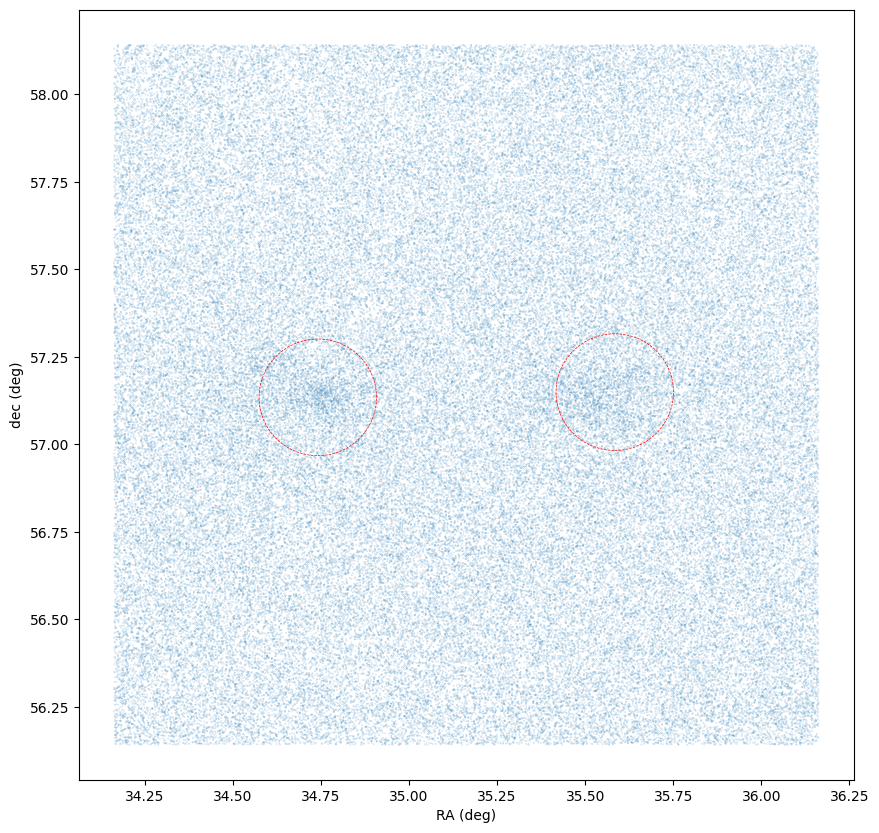

In [127]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
s = [mag**(-1.7) for mag in r['phot_g_mean_mag']]

core_radius = u.Quantity(10, u.arcmin).to(u.deg)

#plt.title("Sky position of all stars in 2 deg box with core membership sky locations")
plt.scatter(r['ra'], r['dec'], s)
figure = plt.gcf()
axes = figure.gca()

ngc869_circle = plt.Circle((cluster_ngc869.ra.deg, cluster_ngc869.dec.deg), core_radius.value, fill=False, linestyle = '--', color = 'red', linewidth=0.5)
ngc884_circle = plt.Circle((cluster_ngc884.ra.deg, cluster_ngc884.dec.deg), core_radius.value, fill=False, linestyle = '--', color = 'red', linewidth=0.5)

axes.add_patch(ngc869_circle)
axes.add_patch(ngc884_circle)

plt.xlabel("RA (deg)")
plt.ylabel("dec (deg)")

plt.savefig("../tex/figures/skypos.png")


### Proper motion criteria

For determining cluster membership, I'm first going to derive proper motion criteria from fitting the cluster center, which should have more cluster stars than field stars. Then using that criteria, I will return to a larger box search and apply proper motion bounds as a filter for membership. This is along the lines of Zhong's analysis, but the principle is sound. Because membership in the cluster is supposed to mean that these stars were all together in the past, that should show up most strongly in proper motion space. Examining the cluster centers to determine proper motion bounds, gives me a good way to remove the influence of stray field stars from that estimate. 

To demonstrate this effect qualitatively, I've generated two plots of the sample stars in proper motion space. The first plot includes all stars in the 2 degree box search. The lump given by the cluster is clearly visible and corresponds to the double-cluster. The second plot has the same axes, but the input sources are restricted to the core stars, within 10 arcmin of the known cluster centers. The same lump in proper-motion space is visible and much stronger in comparison to the background. 

This reduction in the influence of field stars will become important in fitting in pmra (proper motion right-ascension) gaussian. On both plots the over-density corresponding to the double cluster is very nearly centered in right-ascension space on the gaussian distribution of field stars.

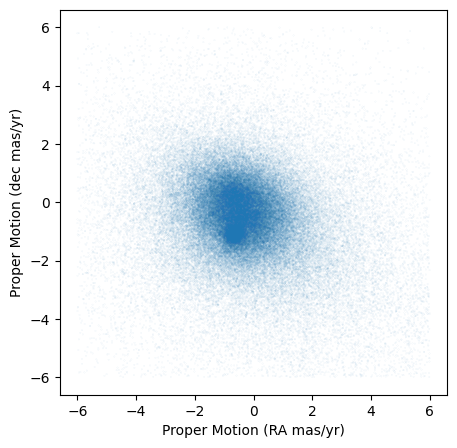

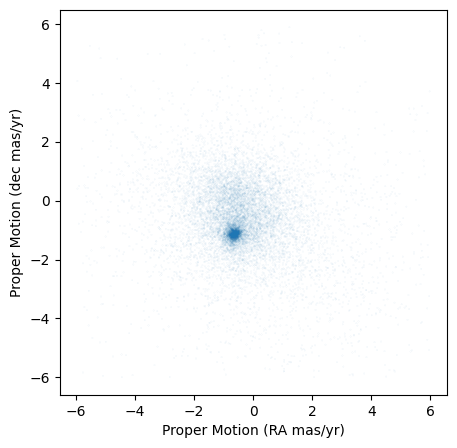

In [50]:
from numpy import ma
import warnings
from astropy.modeling import models, fitting
import astropy.io.misc as misc

def pm_scatter_plot(r, mask=None, pmspace_lim = 6):
    pmra = np.ma.array(r['pmra'], mask=mask)
    pmdec = np.ma.array(r['pmdec'], mask=mask)
    s = [0.0005 for a in pmra]
    plt.scatter(ma.masked_outside(pmra,-pmspace_lim, pmspace_lim), ma.masked_outside(pmdec,-pmspace_lim, pmspace_lim), s)
    plt.xlabel("Proper Motion (RA mas/yr)")
    plt.ylabel("Proper Motion (dec mas/yr)")

core_ngc869_member = [(separation < core_radius.value) for separation in r['separation_ngc_869'] ]
core_ngc884_member = [(separation < core_radius.value) for separation in r['separation_ngc_884'] ]
core_member = np.logical_or(core_ngc884_member,core_ngc869_member)

plt.rcParams["figure.figsize"] = (5,5)

#plt.title("Scatter of all stars in 2 deg box in proper motion space")
pm_scatter_plot(r)

plt.savefig("../tex/figures/pmscatter1.png")
plt.show()

#plt.title("Scatter of core stars in 2 deg box in proper motion space")
pm_scatter_plot(r, np.logical_not(core_member))
plt.savefig("../tex/figures/pmscatter2.png")
plt.show()


The figures below show the fits in ra and dec proper motion space respectively. Only stars within the 10 arc-minute core radius are included. Blue indicates the histogram data from gaia. Red is the fit of the background, green is the fit for the cluster, and yellow is the sum of the two fits. I haven't calculated chisq or other goodness of fit below; however, the plots qualitatively indicate a good fit in proper motion space.

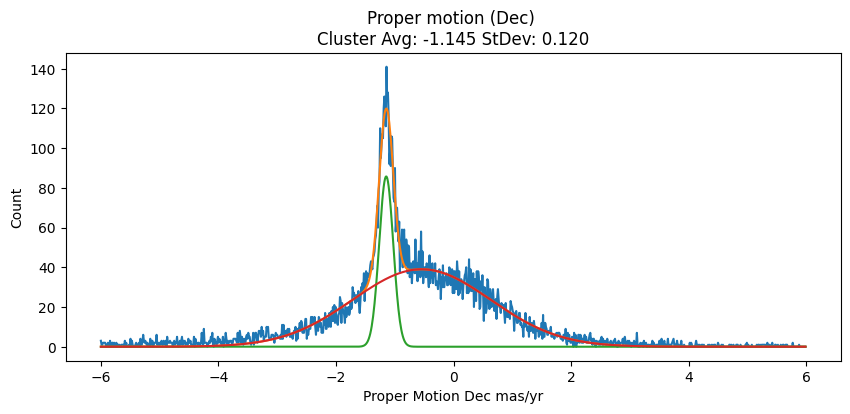

In [51]:
pmdata = np.ma.array(r['pmdec'], mask=np.logical_not(core_member))

fit = fitting.LevMarLSQFitter()
heights, bins = np.histogram(pmdata.compressed(), bins=1000, range=(-6,6))

background = models.Gaussian1D(40, 0, 2, name="background")
cluster = models.Gaussian1D(150, -1, 0.1, name="cluster")
gg_init = background + cluster

fitted_gaussian = fit(gg_init, bins[:-1], heights, maxiter=1000)

plt.rcParams["figure.figsize"] = (10,4)

plt.title(f"Proper motion (Dec) \nCluster Avg: {fitted_gaussian['cluster'].parameters[1]:.3f} StDev: {fitted_gaussian['cluster'].parameters[2]:.3f}")
plt.xlabel("Proper Motion Dec mas/yr")
plt.ylabel("Count")
plt.plot(bins[:-1], heights)
plt.plot(bins[:-1], fitted_gaussian(bins[:-1]))
plt.plot(bins[:-1], fitted_gaussian['cluster'](bins[:-1]))
plt.plot(bins[:-1], fitted_gaussian['background'](bins[:-1]))
plt.savefig("../tex/figures/pmdec_fit.png")
plt.show()

#print(fit.fit_info['message'])
#print(fitted_gaussian['cluster'])

pmdec_fit = fitted_gaussian['cluster']

misc.fnpickle(pmdec_fit, "../data/pmdec_fit.dat")

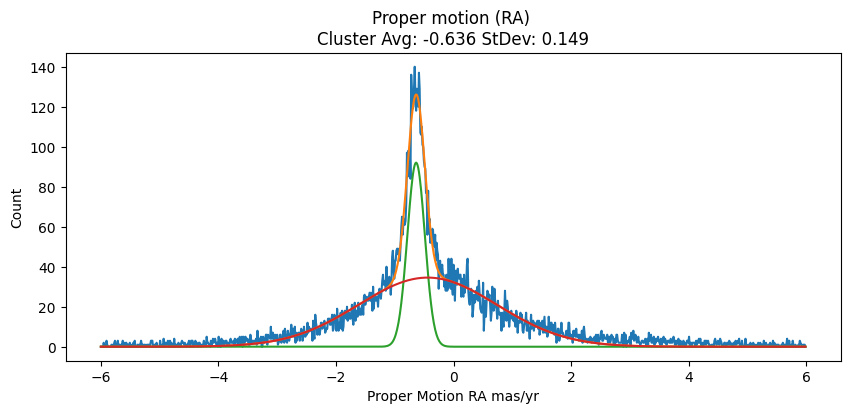

In [52]:
pmdata = np.ma.array(r['pmra'], mask=np.logical_not(core_member))

fit = fitting.LevMarLSQFitter()
heights, bins = np.histogram(pmdata.compressed(), bins=1000, range=(-6,6))

background = models.Gaussian1D(40, 0, 3, name="background")
cluster = models.Gaussian1D(100, -0.5, 0.1, name="cluster")
gg_init = background + cluster

fitted_gaussian = fit(gg_init, bins[:-1], heights, maxiter=1000)

plt.rcParams["figure.figsize"] = (10,4)

plt.title(f"Proper motion (RA) \nCluster Avg: {fitted_gaussian['cluster'].parameters[1]:.3f} StDev: {fitted_gaussian['cluster'].parameters[2]:.3f}")
plt.xlabel("Proper Motion RA mas/yr")
plt.ylabel("Count")
plt.plot(bins[:-1], heights)
plt.plot(bins[:-1], fitted_gaussian(bins[:-1]))
plt.plot(bins[:-1], fitted_gaussian['cluster'](bins[:-1]))
plt.plot(bins[:-1], fitted_gaussian['background'](bins[:-1]))
plt.savefig("../tex/figures/pmra_fit.png")
plt.show()

#print(fit.fit_info['message'])
#print(fitted_gaussian['cluster'])

pmra_fit = fitted_gaussian['cluster']
misc.fnpickle(pmra_fit, "../data/pmra_fit.dat")

In [53]:
print(pmra_fit.parameters)
print(pmdec_fit.parameters)

[92.04565858 -0.63610421  0.14871692]
[85.78815082 -1.14525651  0.11978877]


Further visualizing the fit here, I'm projecting a 2-sigma ellipse in proper motion space over the prior scatter plots. The two sigma boundary seems to clearly encompass the overdensity in proper-motion space for the entire two degree field. Were I to use only this proper motion criteria for cluster membership, in the 2 degree field I'd get 7289 stars. This is a bit too many given the literature, so I'm going to look at distances next to try to narrow membership down.

Count of all stars in 2 degree box identified by proper motion:  7248
Count of core stars identified by proper motions:  2290


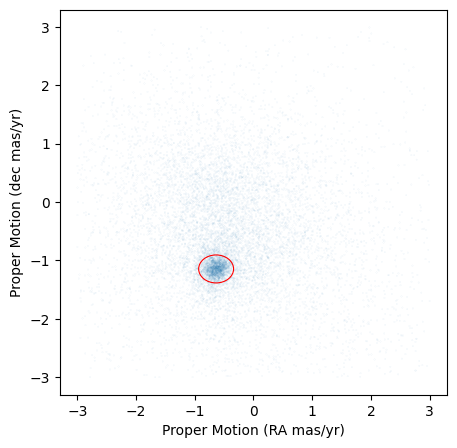

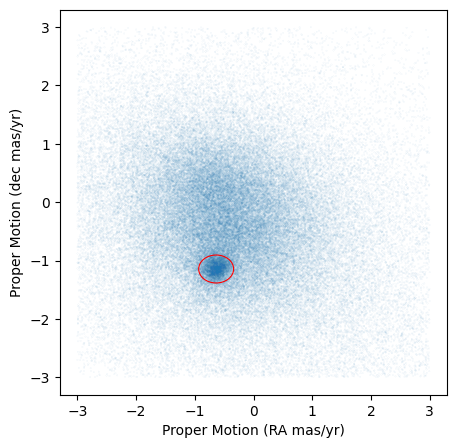

In [62]:
# We are a member based on proper motion if the star is in the elipse defined by pmra fit gaussians at 1 sigma
pmra_center = pmra_fit.parameters[1]
pmdec_center = pmdec_fit.parameters[1]
pmra_extent = pmra_fit.parameters[2] *2
pmdec_extent = pmdec_fit.parameters[2] *2
member_pmdata = [(pmra-pmra_center)**2/pmra_extent**2 + (pmdec-pmdec_center)**2/pmra_extent**2 < 1 for pmra,pmdec in zip(r['pmra'],r['pmdec']) ]

print("Count of all stars in 2 degree box identified by proper motion: ", np.count_nonzero(member_pmdata))
print("Count of core stars identified by proper motions: ", np.count_nonzero(np.logical_and(member_pmdata, core_member)))

plt.rcParams["figure.figsize"] = (5,5)

#plt.title("Core stars only")
pm_scatter_plot(r, mask=np.logical_not(core_member), pmspace_lim=3)
import matplotlib.patches as patches
figure = plt.gcf()
axes = figure.gca()
pm_criteria = patches.Ellipse((pmra_center, pmdec_center), pmra_extent*2, pmdec_extent*2, fill=False, linestyle = '-', color = 'red', linewidth=0.8)
axes.add_patch(pm_criteria)

plt.savefig("../tex/figures/pmscatter_fit1.png")
plt.show()


#plt.title("All stars in 2 degree box")
pm_scatter_plot(r, pmspace_lim=3)
import matplotlib.patches as patches
figure = plt.gcf()
axes = figure.gca()
pm_criteria = patches.Ellipse((pmra_center, pmdec_center), pmra_extent*2, pmdec_extent*2, fill=False, linestyle = '-', color = 'red', linewidth=0.8)
axes.add_patch(pm_criteria)
plt.savefig("../tex/figures/pmscatter_fit2.png")
plt.show()

### Distance criteria

Examining now the Bailer-Jones distances to all stars identified by proper motion in both the two degree field and in the core, the major difference is the thickness of the tail of the distribution. This is indicative that applying only the proper motion criteria to a wider sample, will result in misidentifying some field stars as cluster members. I'm therefore going to add a proper motion criteria gained from fitting this histogram with a single gaussian.

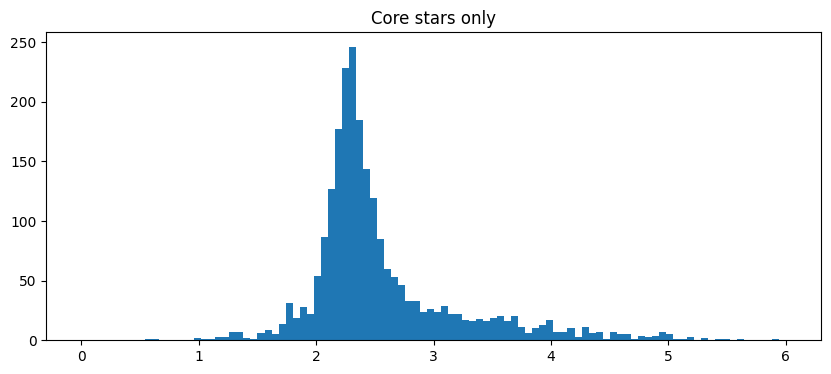

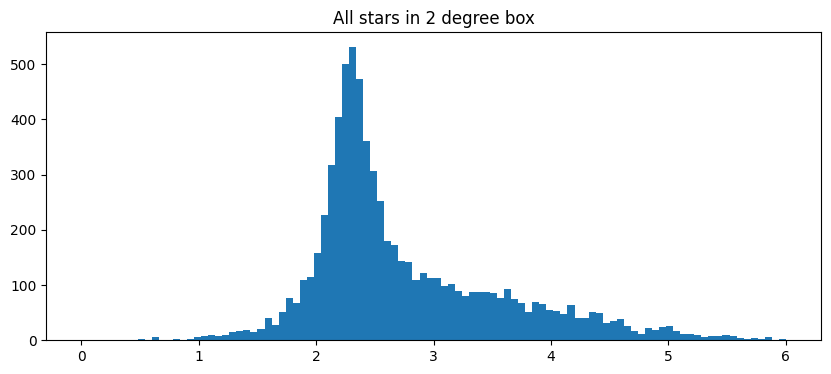

In [63]:
def dist_hist(r, mask_criteria):
    distances = np.ma.array(r['r_med_geo']/1000, mask=mask_criteria)    
    plt.hist(distances.compressed(), bins=100, range=(0,6))
    
plt.rcParams["figure.figsize"] = (10,4)

plt.title("Core stars only")
dist_hist(r, np.logical_not(np.logical_and(member_pmdata, core_member)))
plt.show()


plt.title("All stars in 2 degree box")
dist_hist(r, np.logical_not(member_pmdata))
plt.show()

This next plot is a fit of a double gaussian to the distances of the core stars identified by proper-motion criteria. The plot shows the Bailer-Jones distances in blue, the total fit in yellow, the background in red, and the cluster fit in green. 

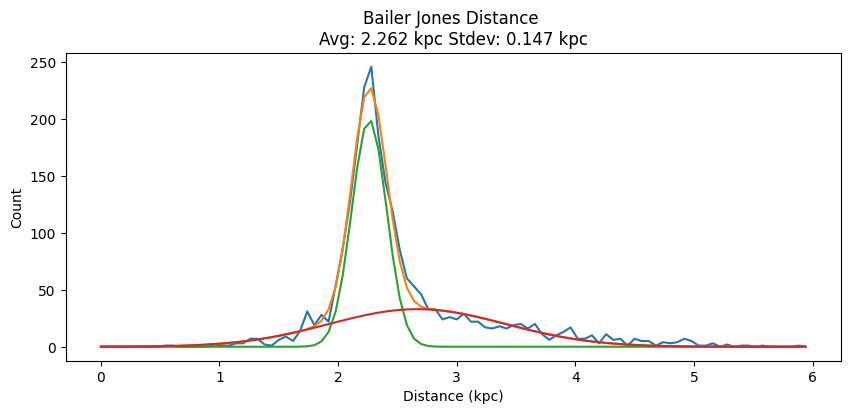

Model: Gaussian1D
Name: cluster
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean             stddev      
    ------------------ ----------------- ------------------
    199.75311365282377 2.262249619022899 0.1465050787064225


In [64]:
distdata = np.ma.array(r['r_med_geo']/1000, mask=np.logical_not(np.logical_and(member_pmdata, core_member)))
#distdata = np.ma.array(r['distance_gspphot']/1000, mask=np.logical_not(np.logical_and(member_pmdata, core_member)))

fit = fitting.LevMarLSQFitter()

heights, bins = np.histogram(distdata.compressed(), bins=100, range=(0,6))

background = models.Gaussian1D(40, 3, 3, name="background")
cluster = models.Gaussian1D(250, 2.3, 0.2, name="cluster")
gg_init = background + cluster

fitted_gaussian = fit(gg_init, bins[:-1], heights, maxiter=1000)

plt.rcParams["figure.figsize"] = (10,4)

plt.title(f"Bailer Jones Distance \nAvg: {fitted_gaussian['cluster'].parameters[1]:.3f} kpc Stdev: {fitted_gaussian['cluster'].parameters[2]:.3f} kpc")
plt.xlabel("Distance (kpc)")
plt.ylabel("Count")
plt.plot(bins[:-1], heights)
plt.plot(bins[:-1], fitted_gaussian(bins[:-1]))
plt.plot(bins[:-1], fitted_gaussian['cluster'](bins[:-1]))
plt.plot(bins[:-1], fitted_gaussian['background'](bins[:-1]))
plt.savefig("../tex/figures/bjdist_fit.png")
plt.show()

#print(fit.fit_info['message'])
#print(fitted_gaussian['cluster'])

dist_fit = fitted_gaussian['cluster']
print(dist_fit)

misc.fnpickle(dist_fit, "../data/dist_fit.dat")

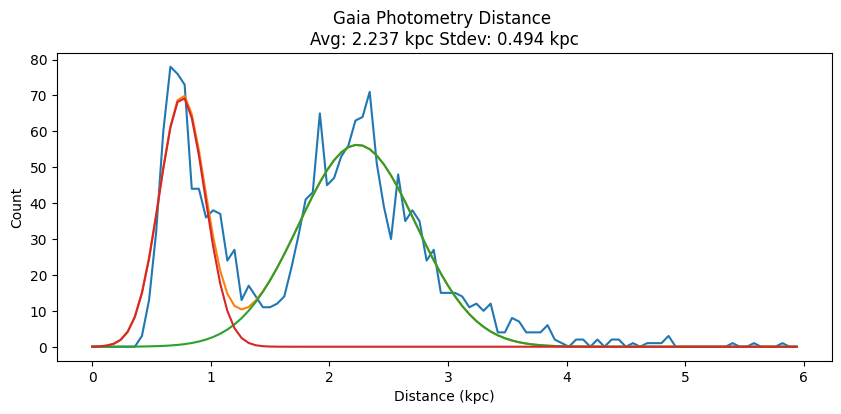

In [65]:
distdata = np.ma.array(r['distance_gspphot']/1000, mask=np.logical_not(np.logical_and(member_pmdata, core_member)))
#distdata = np.ma.array(r['distance_gspphot']/1000, mask=np.logical_not(np.logical_and(member_pmdata, core_member)))

fit = fitting.LevMarLSQFitter()

heights, bins = np.histogram(distdata.compressed(), bins=100, range=(0,6))

background = models.Gaussian1D(40, 3, 3, name="background")
cluster = models.Gaussian1D(250, 2.3, 0.2, name="cluster")
gg_init = background + cluster

fitted_gaussian = fit(gg_init, bins[:-1], heights, maxiter=1000)

plt.rcParams["figure.figsize"] = (10,4)

plt.title(f"Gaia Photometry Distance \nAvg: {fitted_gaussian['cluster'].parameters[1]:.3f} kpc Stdev: {fitted_gaussian['cluster'].parameters[2]:.3f} kpc")
plt.xlabel("Distance (kpc)")
plt.ylabel("Count")
plt.plot(bins[:-1], heights)
plt.plot(bins[:-1], fitted_gaussian(bins[:-1]))
plt.plot(bins[:-1], fitted_gaussian['cluster'](bins[:-1]))
plt.plot(bins[:-1], fitted_gaussian['background'](bins[:-1]))
plt.savefig("../tex/figures/gaiadist_fit.png")
plt.show()

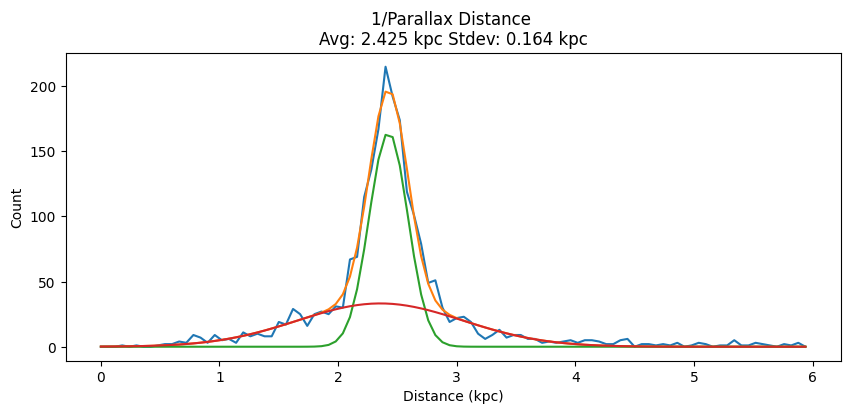

In [66]:
distdata = np.ma.array(1/r['parallax'], mask=np.logical_not(np.logical_and(member_pmdata, core_member)))
#distdata = np.ma.array(r['distance_gspphot']/1000, mask=np.logical_not(np.logical_and(member_pmdata, core_member)))

fit = fitting.LevMarLSQFitter()

heights, bins = np.histogram(distdata.compressed(), bins=100, range=(0,6))

background = models.Gaussian1D(40, 3, 3, name="background")
cluster = models.Gaussian1D(250, 2.3, 0.2, name="cluster")
gg_init = background + cluster

fitted_gaussian = fit(gg_init, bins[:-1], heights, maxiter=1000)

plt.rcParams["figure.figsize"] = (10,4)

plt.title(f"1/Parallax Distance \nAvg: {fitted_gaussian['cluster'].parameters[1]:.3f} kpc Stdev: {fitted_gaussian['cluster'].parameters[2]:.3f} kpc")
plt.xlabel("Distance (kpc)")
plt.ylabel("Count")
plt.plot(bins[:-1], heights)
plt.plot(bins[:-1], fitted_gaussian(bins[:-1]))
plt.plot(bins[:-1], fitted_gaussian['cluster'](bins[:-1]))
plt.plot(bins[:-1], fitted_gaussian['background'](bins[:-1]))
plt.savefig("../tex/figures/parallaxdist_fit.png")
plt.show()


Using a 1-sigma criteria for membership in distance space, and combining that with the proper motion criteria gives us a triaxial volume in the space of pmdec,pmra,dist which will be used as the filter for cluster membership. Cluster members determined using this total criteria in the 2 degree field are 1862 in number, with 847 of those stars existing within 10 arcmin of the cluster center.

NOTE: This choice of 1sigma vs 2 for the proper motion space probably needs justification. I believe the field star contamination is lower from the plots. I want to look at CMD though

[1.99753114e+02 2.26224962e+00 1.46505079e-01]
Count of core stars identified by combined criteria  1266
Count of 2 degree stars identified by combined criteria  2961
2961 2961 2961


/home/mtauraso/astr511-hw2/.snakemake/conda/9f6bfdea3ec59e9e32ddf47f2c61ee75_/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


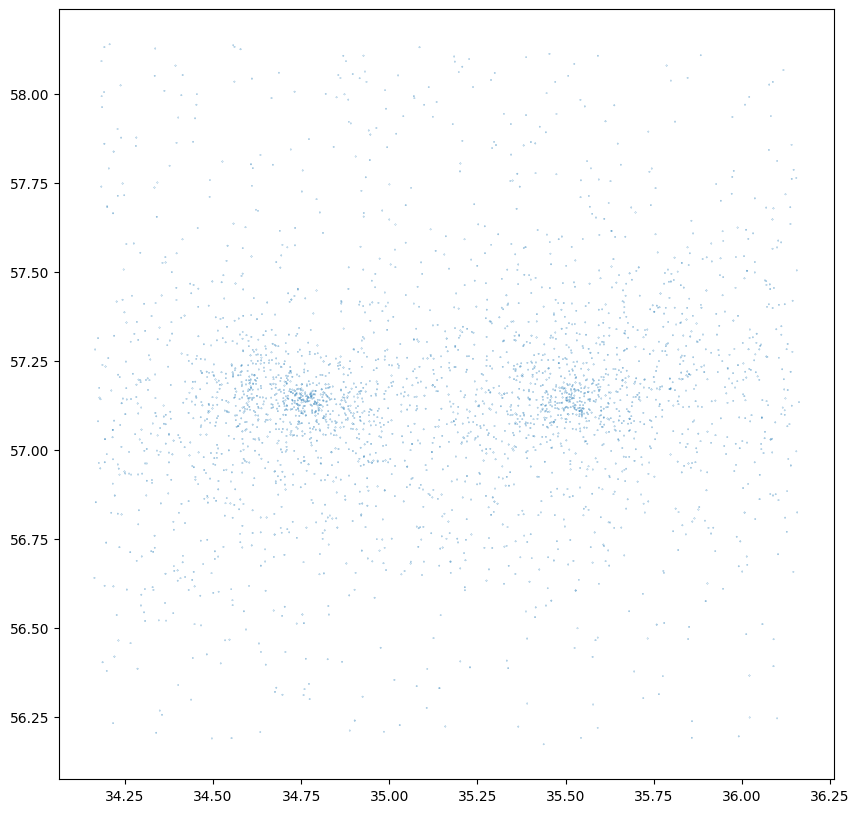

In [67]:
dist_center = dist_fit.parameters[1]
dist_extent = dist_fit.parameters[2]*2

print(dist_fit.parameters)

member_all = [(pmra-pmra_center)**2/pmra_extent**2 + 
              (pmdec-pmdec_center)**2/pmra_extent**2 +
              (dist-dist_center)**2/dist_extent**2 < 1 for pmra,pmdec,dist in zip(r['pmra'],r['pmdec'],r['r_med_geo']/1000) ]

print("Count of core stars identified by combined criteria ", np.count_nonzero(np.logical_and(core_member, member_all)))
print("Count of 2 degree stars identified by combined criteria ", np.count_nonzero(member_all))

def sky_scatter(r, mask_criteria, mag_dotsize_exponent=-1.75):
    ra = np.ma.array(r['ra'], mask=mask_criteria)
    dec = np.ma.array(r['dec'], mask=mask_criteria)
    mags = np.ma.array(r['phot_g_mean_mag'], mask=mask_criteria)
    
    print(ma.count(ra), ma.count(dec), ma.count(mags))

    s = [mag**(mag_dotsize_exponent) for mag in mags]
    plt.scatter(ra, dec, s)
    #plt.show()

    
plt.rcParams["figure.figsize"] = (10,10)
sky_scatter(r, np.logical_not(member_all), mag_dotsize_exponent=-1.25)
plt.show()

In [108]:
# Generate a 2 d histogram of 1 arcmin boxes sorting all stars into a box
h, xbins, ybins = np.histogram2d(np.ma.array(r['ra'], mask=member_all).value, np.ma.array(r['dec'], mask=member_all).value, bins=(120,120))

center_ra = np.zeros((120,120))
center_dec = np.zeros((120,120))
r_ngc869 = np.zeros((120,120))
r_ngc884 = np.zeros((120,120))


# Generate distances from cluster center for every box.
for xidx, (xmin, xmax) in enumerate(zip(xbins, xbins[1:])):
    for yidx, (ymin, ymax) in enumerate(zip(ybins, ybins[1:])):
        center_ra[xidx][yidx] = (xmin + xmax)/2.0
        center_dec[xidx][yidx] = (ymin + ymax)/2.0
        
        bin_center = SkyCoord( ra = (xmin + xmax)/2.0, dec = (ymin + ymax)/2.0, unit=(u.degree, u.degree), frame='icrs')
        r_ngc869[xidx][yidx] = cluster_ngc869.separation(bin_center).to(u.arcmin).value
        r_ngc884[xidx][yidx] = cluster_ngc884.separation(bin_center).to(u.arcmin).value
        


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Model: density_profile_both
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
       n_background       n_0_ngc869         n_0_ngc884      R_crit_ngc869     R_crit_ngc884  
    ----------------- ------------------ ----------------- ----------------- -----------------
    8.187308378617141 11.387666278264078 6.579589191319029 3.193766243113789 4.812282701651674
dms_tuple(d=0.0, m=3.0, s=11.625974586827352)
dms_tuple(d=0.0, m=4.0, s=48.73696209910045)
2961 2961 2961


/home/mtauraso/astr511-hw2/.snakemake/conda/9f6bfdea3ec59e9e32ddf47f2c61ee75_/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


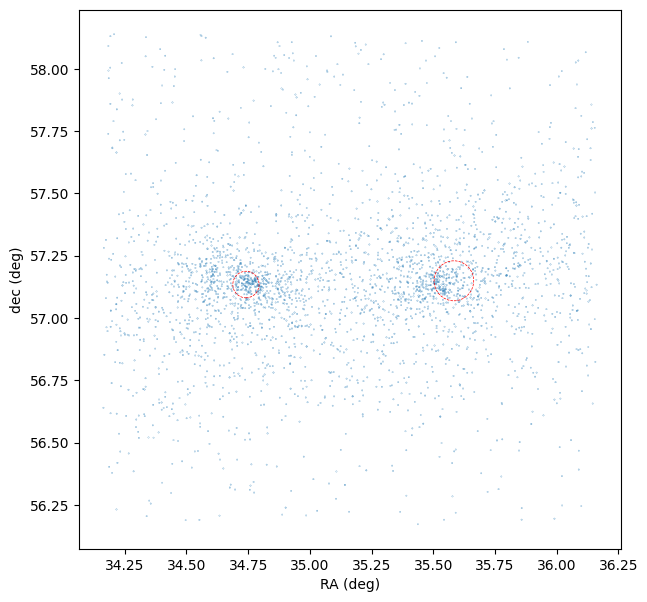

In [139]:
# Make a custom model using astropy models which assumes the centers of both clusters (ra, dec), (ra,dec) and fits 5 paremeters n_bck, n_0left, n_0right, r_crit_left, r_crit_right
from astropy.modeling.models import custom_model

@custom_model
def density_profile_both(r_ngc869, r_ngc884, 
                         n_background = 0, 
                         n_0_ngc869 = 20, 
                         n_0_ngc884 = 20,
                         R_crit_ngc869 = 3, 
                         R_crit_ngc884 = 3):
    
    return n_background + n_0_ngc869/(1+(r_ngc869/R_crit_ngc869)**2) + n_0_ngc884/(1+(r_ngc884/R_crit_ngc884)**2)

# Pass all the distances and all the values into the fit
fit = fitting.LevMarLSQFitter()

# Fit with centers defined
initial_profile = density_profile_both(n_background = 5, n_0_ngc869 = 20, n_0_ngc884 = 20, R_crit_ngc869 = 3, R_crit_ngc884 = 3)
fitted_profile_both = fit(initial_profile, r_ngc869, r_ngc884, h, maxiter=1000)

print(fit.fit_info['message'])
print(fitted_profile_both)
print(Angle(fitted_profile_both.parameters[3]*u.arcmin).dms)
print(Angle(fitted_profile_both.parameters[4]*u.arcmin).dms)

# Scatter plot the critical radii to visualize the fit.

plt.rcParams["figure.figsize"] = (7,7)
sky_scatter(r, np.logical_not(member_all), mag_dotsize_exponent=-1.25)

figure = plt.gcf()
axes = figure.gca()

ngc869_circle = plt.Circle((cluster_ngc869.ra.deg, cluster_ngc869.dec.deg), fitted_profile_both.parameters[3]/60, fill=False, linestyle = '--', color = 'red', linewidth=0.5)
ngc884_circle = plt.Circle((cluster_ngc884.ra.deg, cluster_ngc884.dec.deg), fitted_profile_both.parameters[4]/60, fill=False, linestyle = '--', color = 'red', linewidth=0.5)

axes.add_patch(ngc869_circle)
axes.add_patch(ngc884_circle)
plt.xlabel("RA (deg)")
plt.ylabel("dec (deg)")
plt.savefig("../tex/figures/rcrit.png")

plt.show()





The relative error between two consecutive iterates is at most 0.000000
Model: density_profile_var
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
      n_background       n_0_ngc869        n_0_ngc884      R_crit_ngc869     R_crit_ngc884       ra_ngc869         dec_ngc869        ra_ngc884          dec_ngc884   
    ---------------- ------------------ ---------------- ----------------- ----------------- ----------------- ----------------- ------------------ -----------------
    8.21029626829153 11.782780491654947 8.02467264322427 3.036052498039207 4.088613050352847 34.74270142449946 57.13561496551305 35.518535515608036 57.13382077055177
dms_tuple(d=0.0, m=3.0, s=2.1631498823524176)
dms_tuple(d=0.0, m=4.0, s=5.31678302117081)
<SkyCoord (ICRS): (ra, dec) in deg
    (34.741, 57.134)> <SkyCoord (ICRS): (ra, dec) in deg
    (35.584, 57.149)>
2961 2961 2961


/home/mtauraso/astr511-hw2/.snakemake/conda/9f6bfdea3ec59e9e32ddf47f2c61ee75_/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


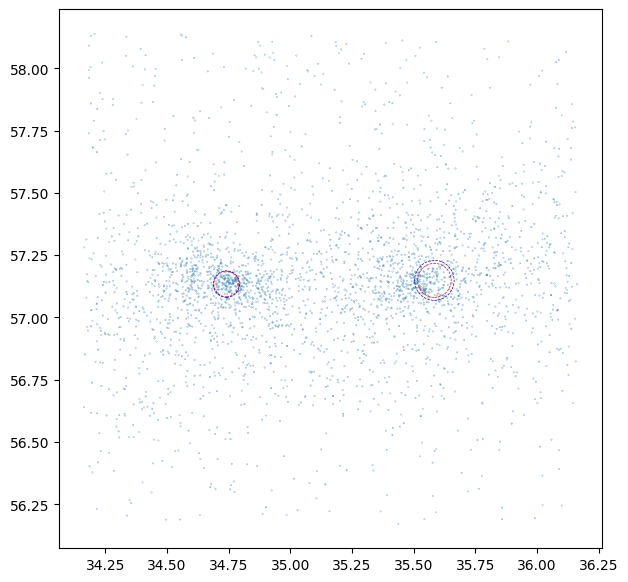

In [134]:
# Make a custom model using astropy models which assumes the centers of both clusters (ra, dec), (ra,dec) and fits 5 paremeters n_bck, n_0left, n_0right, r_crit_left, r_crit_right
from astropy.modeling.models import custom_model
from astropy.coordinates import Angle


@custom_model
def density_profile_var(center_ra, center_dec, 
                         n_background = 0, 
                         n_0_ngc869 = 20, 
                         n_0_ngc884 = 20,
                         R_crit_ngc869 = 3, 
                         R_crit_ngc884 = 3,
                         ra_ngc869 = cluster_ngc869.ra.deg,
                         dec_ngc869 = cluster_ngc869.dec.deg,
                         ra_ngc884 = cluster_ngc884.ra.deg,
                         dec_ngc884 = cluster_ngc884.dec.deg,):
    center = SkyCoord(center_ra, center_dec, unit=(u.degree, u.degree), frame='icrs')
    r_ngc869 = SkyCoord(ra_ngc869, dec_ngc869, unit=(u.degree, u.degree), frame='icrs').separation(center).to(u.arcmin).value
    r_ngc884 = SkyCoord(ra_ngc884, dec_ngc884, unit=(u.degree, u.degree), frame='icrs').separation(center).to(u.arcmin).value
    
    return n_background + n_0_ngc869/(1+(r_ngc869/R_crit_ngc869)**2) + n_0_ngc884/(1+(r_ngc884/R_crit_ngc884)**2)

# Pass all the distances and all the values into the fit
fit = fitting.LevMarLSQFitter()

# Fit with centers variable
initial_profile = density_profile_var(n_background = 5, n_0_ngc869 = 20, n_0_ngc884 = 20, R_crit_ngc869 = 3, R_crit_ngc884 = 3, 
                                      ra_ngc869 = cluster_ngc869.ra.deg, dec_ngc869 = cluster_ngc869.dec.deg,
                                      ra_ngc884 = cluster_ngc884.ra.deg, dec_ngc884 = cluster_ngc884.dec.deg)

fitted_profile = fit(initial_profile, center_ra, center_dec, h, maxiter=1000)

print(fit.fit_info['message'])
print(fitted_profile)
print(Angle(fitted_profile.parameters[3]*u.arcmin).dms)
print(Angle(fitted_profile.parameters[4]*u.arcmin).dms)
print(cluster_ngc869, cluster_ngc884)

# Scatter plot the critical radii to visualize the fit.

plt.rcParams["figure.figsize"] = (7,7)
sky_scatter(r, np.logical_not(member_all), mag_dotsize_exponent=-1.25)

figure = plt.gcf()
axes = figure.gca()

ngc869_circle = plt.Circle((cluster_ngc869.ra.deg, cluster_ngc869.dec.deg), fitted_profile.parameters[3]/60, fill=False, linestyle = '--', color = 'red', linewidth=0.5)
ngc884_circle = plt.Circle((cluster_ngc884.ra.deg, cluster_ngc884.dec.deg), fitted_profile.parameters[4]/60, fill=False, linestyle = '--', color = 'red', linewidth=0.5)

axes.add_patch(ngc869_circle)
axes.add_patch(ngc884_circle)

ngc869_circle = plt.Circle((cluster_ngc869.ra.deg, cluster_ngc869.dec.deg), fitted_profile_both.parameters[3]/60, fill=False, linestyle = '--', color = 'blue', linewidth=0.5)
ngc884_circle = plt.Circle((cluster_ngc884.ra.deg, cluster_ngc884.dec.deg), fitted_profile_both.parameters[4]/60, fill=False, linestyle = '--', color = 'blue', linewidth=0.5)

axes.add_patch(ngc869_circle)
axes.add_patch(ngc884_circle)

plt.show()
# TODO: It is not looking like your centers are lined up with your member stars, esp on the right cluster
#
#     Make the cluster centers part of the fit. Precomputation is the ra,dec for the bin. bin ra dec is input to model
#     The 4 parameter sky positions are model parameters, and should have initial values from Simbad
#
# Angles for discussion: What does the literature say about the sky locations? (Bragg talks about this)
#          

Applying this same criteria to the broad field of 7.5 degrees of sky gives 3897 cluster members. There's a little bit of overdensity visible on the right of the plot, which might indicate some sort of extended structure.

6837 6837 6837


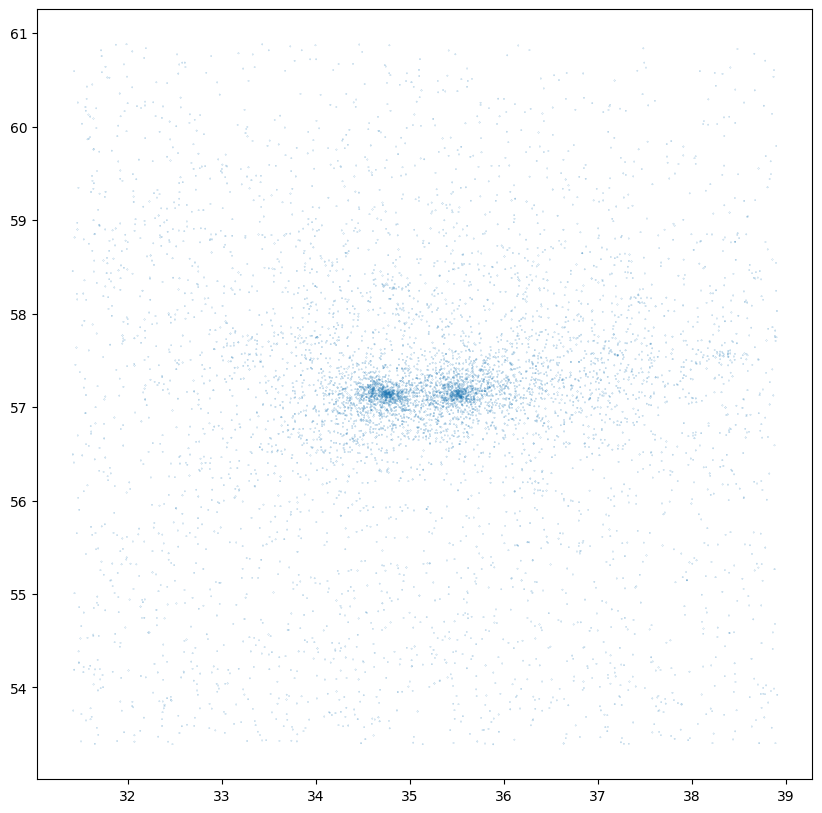

CPU times: user 2min 14s, sys: 210 ms, total: 2min 15s
Wall time: 2min 15s


In [68]:
%%time 
# About 2 minutes to run this

# Re do for broad data
r_broad=Table.read('../data/Cluster-broad.hdf5', format='hdf5')
#r_broad.info()

member_all_broad = [(pmra-pmra_center)**2/pmra_extent**2 + 
              (pmdec-pmdec_center)**2/pmra_extent**2 +
              (dist-dist_center)**2/dist_extent**2 < 1 for pmra,pmdec,dist in zip(r_broad['pmra'],r_broad['pmdec'],r_broad['r_med_geo']/1000) ]

plt.rcParams["figure.figsize"] = (10,10)
sky_scatter(r_broad, np.logical_not(member_all_broad), mag_dotsize_exponent=-1.5)
plt.show()